In [4]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import os
import seaborn as sns
from itertools import product
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor



def save_for_submission(array, name):
    temp_subm = sample_submussion.copy()
    temp_subm['item_cnt_month'] = array
    temp_subm.to_csv(name, index=False)
    
    
def rmse(X, y):
    return np.sqrt(np.mean((X - y) ** 2))
    

sample_submussion = pd.read_csv("/home/maksim/ml/Predict future sales/Submissions/sample_submission.csv")

# Read the Data

In [3]:
items = pd.read_csv("/home/maksim/ml/Predict future sales/items.csv")
shops = pd.read_csv("/home/maksim/ml/Predict future sales/shops.csv")
test = pd.read_csv("/home/maksim/ml/Predict future sales/test.csv")
sales_train = pd.read_csv("/home/maksim/ml/Predict future sales/sales_train.csv")
item_categories = pd.read_csv("/home/maksim/ml/Predict future sales/item_categories.csv")

# Data overview

In [4]:
print("Train shape ", sales_train.shape)
print("Test shape ", test.shape)

Train shape  (2935849, 6)
Test shape  (214200, 3)


In [5]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [6]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [7]:
print("Number of nulls in sales_train = {}".format(np.sum(sales_train.isnull().sum())))
print("Number of duplicates in sales_train = {}".format(len(sales_train[sales_train.duplicated()])))

Number of nulls in sales_train = 0
Number of duplicates in sales_train = 6


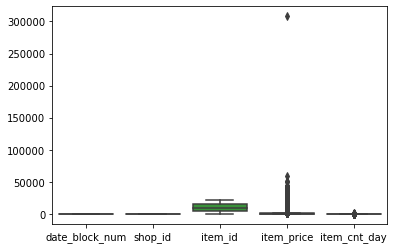

In [8]:
sns.boxplot(data=sales_train)
plt.show()

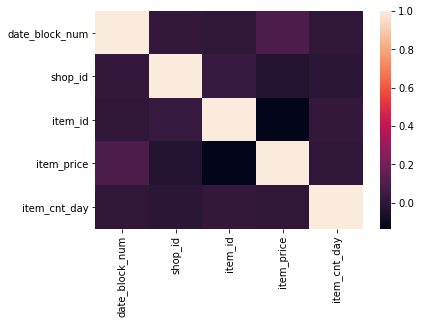

In [9]:
sns.heatmap(sales_train.corr())
plt.show()

# Dataset Creation

In [10]:
grid = []
for month in sales_train.date_block_num.unique():
    sales_train_month = sales_train[sales_train.date_block_num == month]
    shops_month = sales_train_month.shop_id.unique()
    items_month = sales_train_month.item_id.unique()
    grid.append(np.array(list(product(shops_month, items_month, [month])), dtype='int32'))
index_cols = ['shop_id', 'item_id', 'date_block_num']
grid = pd.DataFrame(np.vstack(grid), columns = index_cols)

In [11]:
sales_train['item_cnt_day'] = sales_train['item_cnt_day'].clip(0,20)

In [12]:
groups = sales_train.groupby(index_cols)
trainset = groups.agg({'item_price': 'mean','item_cnt_day': 'sum'}).reset_index()
trainset.rename(columns = {'item_cnt_day' : 'item_cnt_month'}, inplace=True)

In [13]:
trainset['item_cnt_month'] = trainset['item_cnt_month'].clip(0,20)
trainset = pd.merge(grid, trainset, how='left', on=index_cols)
trainset.item_cnt_month = trainset.item_cnt_month.fillna(0)
trainset = pd.merge(trainset,items[['item_id','item_category_id']], on='item_id')

In [14]:
month_data = sales_train.groupby(['item_id','date_block_num'])['item_price'].agg('mean').reset_index()
merged_data = pd.merge(trainset, month_data, how='left', on=['item_id','date_block_num'])
trainset.item_price = merged_data.item_price_x.fillna(merged_data.item_price_y)

In [127]:
test_mod = test.copy()
test_mod['date_block_num'] = [34 for _ in range(len(test_mod))]
test_mod = pd.merge(test_mod, items[['item_id','item_category_id']], on='item_id')
test_mod = pd.merge(test_mod, month_data.drop_duplicates('item_id', keep='last'), how='left', on='item_id')
test_mod = test_mod.drop('date_block_num_y', axis = 1).fillna(test_mod.item_price.mean())
test_mod = test_mod.rename(columns={'date_block_num_x': 'date_block_num'})
test_mod = test_mod.sort_values(by='ID').reset_index(drop=True)

In [129]:
df = trainset.append(test_mod)
df.to_pickle("/home/maksim/ml/Predict future sales/Pickle_files/how_to_win_1.pkl")

# Feature generation

In [5]:
X_train =  pd.read_pickle("/home/maksim/ml/Predict future sales/Pickle_files/X_train.pkl")
X_val =  pd.read_pickle("/home/maksim/ml/Predict future sales/Pickle_files/X_val.pkl")
y_train = pd.read_pickle("/home/maksim/ml/Predict future sales/Pickle_files/y_train.pkl")

In [6]:
def get_expanding_mean(col, X_train, X_val):
    groups = X_train.groupby(col)
    cumsum = groups.item_cnt_month.cumsum() - y_train
    cumcnt = groups.cumcount()
    X_train['expanding_mean_target_group_' + col] = (cumsum / cumcnt).fillna(0)
    X_val['expanding_mean_target_group_' + col] = X_val[col].map(groups['expanding_mean_target_group_' + col].agg('last')).fillna(0)
    return X_train, X_val


def get_all_expanding_mean(X_train, X_val):
    for col in ['item_id', 'shop_id', 'item_category_id']:
        X_train, X_val = get_expanding_mean(col, X_train, X_val)
    return X_train, X_val 


def get_lag_count(X_train, X_val):
    lag_count = X_train[X_train.date_block_num == 0].item_cnt_month.values
    X_group_item_month = X_train.groupby(['item_id','date_block_num']).item_cnt_month.mean().reset_index()
    for i in range(1, max(X_train.date_block_num) + 1):
        lag_count = np.append(lag_count, pd.merge(X_train[X_train.date_block_num == i], X_group_item_month[X_group_item_month.date_block_num == i-1],
                                 how='left', on=['item_id']).item_cnt_month_y.fillna(0).values)
    X_train['lag_item_cnt_month'] = lag_count
    X_val['lag_item_cnt_month'] = pd.merge(X_val, X_group_item_month[X_group_item_month.date_block_num == max(X_val.date_block_num) - 1],
                                 how='left', on=['item_id']).item_cnt_month_y.fillna(0).values
    return X_train, X_val

def get_shop_features(X_train, X_val):
    data_per_shop = X_train.groupby(['shop_id', 'date_block_num']).agg({"item_id":np.size, "item_price": np.mean }).reset_index()
    data_per_shop.columns = ['shop_id', 'date_block_num', 'amount_items_sold_in_shop_this_month', 'mean_price_in_shop_this_month']
    X_train = pd.merge(X_train, data_per_shop, how='left', on=['shop_id', 'date_block_num'])
    
    val_data_per_shop = X_val.groupby(['shop_id', 'date_block_num']).agg({"item_id":np.size, "item_price": np.mean }).reset_index()
    val_data_per_shop.columns = ['shop_id', 'date_block_num', 'amount_items_sold_in_shop_this_month', 'mean_price_in_shop_this_month']
    X_val = pd.merge(X_val , val_data_per_shop, how='left', on=['shop_id', 'date_block_num'])
    
    return X_train, X_val

def get_month_features(X_train, X_val):
    data_per_month = X_train.groupby('date_block_num').agg({"item_id":np.size, "item_price": np.mean }).reset_index()
    data_per_month.columns = ['date_block_num', 'amount_items_sold_this_month', 'mean_price_this_month']
    X_train = pd.merge(X_train, data_per_month, how='left', on='date_block_num')
    
    val_data_per_month = X_val.groupby('date_block_num').agg({"item_id":np.size, "item_price": np.mean }).reset_index()
    val_data_per_month.columns =  ['date_block_num', 'amount_items_sold_this_month', 'mean_price_this_month']
    X_val = pd.merge(X_val , val_data_per_month, how='left', on='date_block_num')
    
    return X_train, X_val


def get_features_6_month(X_train, X_val):
    item_cnt_6_month = X_train[X_train.date_block_num.isin(range(28,max(X_train.date_block_num) + 1))].groupby(['item_id'])['item_cnt_month'].agg('mean').rename('item_cnt_6_month')
    X_train = pd.merge(X_train, item_cnt_6_month, how='left', on='item_id').fillna(0)
    X_val = pd.merge(X_val, item_cnt_6_month, how='left', on='item_id').fillna(0)
    X_train['is_active_item'] = (X_train.item_cnt_6_month != 0).astype(float)
    X_val = pd.merge(X_val, X_train[['item_id', 'is_active_item']].groupby('item_id')['is_active_item'].agg('last'), how='left', on='item_id').fillna(0)
    
    shop_cnt_6_month = X_train[X_train.date_block_num.isin(range(28,max(X_train.date_block_num) + 1))].groupby(['shop_id'])['item_cnt_month'].agg('mean').rename('shop_cnt_6_month')
    X_train = pd.merge(X_train, shop_cnt_6_month, how='left', on='shop_id').fillna(0)
    X_val = pd.merge(X_val, shop_cnt_6_month, how='left', on='shop_id').fillna(0)
    X_train['is_active_shop'] = (X_train.shop_cnt_6_month != 0).astype(float)
    X_val = pd.merge(X_val, X_train[['shop_id', 'is_active_shop']].groupby('shop_id')['is_active_shop'].agg('last'), how='left', on='shop_id').fillna(0)
    
    return X_train, X_val

def get_features(X_train, X_val, fun_list):
    for fun in fun_list:
        X_train, X_val = fun(X_train, X_val)
    return X_train, X_val

In [7]:
fun_list = [get_all_expanding_mean, get_lag_count, get_shop_features, get_month_features, get_features_6_month]
X_train, X_val = get_features(X_train, X_val, fun_list)

In [20]:
%%time

y_train = X_train.item_cnt_month
y_val = X_val.item_cnt_month

X_train_fit = X_train.drop('item_cnt_month', axis =1)
X_val_fit = X_val.drop('item_cnt_month', axis =1)


model = LGBMRegressor(verbose=2,max_depth=10, num_leaves= 800)
# model = LGBMRegressor(verbose=2, max_depth=20, bagging_fraction=0.5, feature_fraction=0.25, min_child_weight=100, num_leaves= 2000, min_data_in_leaf = 1000)

model.fit(X_train_fit , y_train)
print("X_train rmse: ",rmse(model.predict(X_train_fit), y_train))
print("X_val rmse: ",rmse(model.predict(X_val_fit), y_val))
f_importances = np.array([[X_train_fit.columns[i], model.feature_importances_[i]] for i in range(len(X_train_fit.columns))])
f_importances_sorted = pd.DataFrame(f_importances[(f_importances[:, 1].astype(float)).argsort()])
print(f_importances_sorted)

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.076825
[LightGBM] [Debug] init for col-wise cost 0.000107 seconds, init for row-wise cost 0.493238 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.123113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 2362
[LightGBM] [Info] Number of data points in the train set: 10675678, number of used features: 17
[LightGBM] [Info] Start training from score 0.299710
[LightGBM] [Debug] Trained a tree with leaves = 800 and max_depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 800 and max_depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 800 and max_depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 800 and max_depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 800 and max_depth = 10
[LightGBM] 

In [ ]:
X_train rmse:  0.7185571940027673
X_val rmse:  1.0043582145161585

In [17]:
lgbm = LGBMRegressor(max_depth=20, bagging_fraction=0.5, feature_fraction=0.25, min_child_weight=100, num_leaves= 1500, min_data_in_leaf = 100000)

lgbm_fitted = get_model_results(lgbm, X_train_fit, X_val_fit,  y_train, y_val)

LGBMRegressor(bagging_fraction=0.5, feature_fraction=0.25, learning_rate=0.08,
              max_depth=20, min_child_weight=100, min_data_in_leaf=100000,
              n_estimators=150, num_leaves=1500)
[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] min_data_in_leaf is set=100000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100000
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
X_train rmse:  0.9885564969235431
X_val rmse:  1.0808070536547825
                                               0     1
0                                 is_active_shop    32
1                               item_cnt_6_month   149
2                                 is_active_item   204
3           amount_items_sold_in_shop_this_month   227
4                   amount_items_sold_this_month   260
5                          m

In [ ]:
X_train rmse:  0.9209343352644527
X_val rmse:  1.0231240503686843

### Testing

In [ ]:
X_tr_testing = X_train.append(X_val)
y_tr_testing = y_train.append(y_val)
X_test_testing = X_test

In [10]:
fun_list = [get_all_expanding_mean, get_lag_count, get_shop_features, get_month_features, get_features_6_month]
X_tr_testing, X_test_testing = get_features(X_tr_testing, X_test_testing, fun_list)

In [11]:
lgbm = LGBMRegressor(max_depth=20, bagging_fraction=0.5, feature_fraction=0.25, min_child_weight=100, num_leaves= 1500, 
                     learning_rate=0.06 / 6,  num_iterations=20 * 6)
lgbm.fit(X_tr_testing.drop('item_cnt_month', axis = 1), y_tr_testing)

/home/maksim/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set=0.25, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


LGBMRegressor(bagging_fraction=0.5, feature_fraction=0.25, learning_rate=0.01,
              max_depth=20, min_child_weight=100, num_iterations=120,
              num_leaves=1500)

In [14]:
prediction = lgbm.predict(X_test_testing.drop('item_cnt_month', axis = 1))

In [15]:
prediction

array([0.49588703, 0.16132267, 0.51289753, ..., 0.14490491, 0.12977558,
       0.12848021])

In [16]:
save_for_submission(prediction, 'lgb_subm.csv')

In [21]:
save_for_submission(model.predict(X_test.drop('item_cnt_month',axis=1)), 'lgb_subm.csv')

In [22]:
X_test.drop('item_cnt_month',axis=1)

,shop_id,item_id,date_block_num,item_price,item_category_id,mean_target_group_shop_id,mean_target_group_category_id,expanding_mean_target_group_item_id
0,5,5037,34,1499.000000,19,0.224299,0.175795,2.062706
1,5,5320,34,998.642536,55,0.224299,0.175795,0.000000
2,5,5233,34,1199.000000,19,0.224299,0.175795,1.781609
3,5,5232,34,1190.433333,23,0.224299,0.175795,1.345238
4,5,5268,34,998.642536,20,0.224299,0.175795,0.000000
...,...,...,...,...,...,...,...,...
214195,45,18454,34,99.000000,55,0.310443,0.175795,1.134361
214196,45,16188,34,1359.000000,64,0.310443,0.175795,0.071429
214197,45,15757,34,229.000000,55,0.310443,0.175795,0.237508
214198,45,19648,34,89.100000,40,0.310443,0.175795,0.118943


In [17]:
data_per_month = df.groupby('date_block_num')[['item_id', 'item_price']].agg({"item_id":np.size, "item_price": np.mean }).reset_index()
data_per_month.columns = ['date_block_num', 'amount_items_sold_this_month', 'mean_price_this_month']
df = pd.merge(df,data_per_month, how='left', on='date_block_num')

In [18]:
lag_count = df[df.date_block_num == 0].item_cnt_month
for i in range(1, 35):
    lag_count = lag_count.append(pd.merge(df[df.date_block_num == i], df[df.date_block_num == i-1],
                                 how='left', on=['shop_id', 'item_id']).item_cnt_month_y.fillna(0))
df['lag_item_cnt_month'] =  lag_count.values

In [19]:
actual_items = df[df.date_block_num.isin(range(28,34))].groupby(['item_id'])['item_cnt_month'].agg('sum').rename('item_cnt_6_month')
df = pd.merge(df, actual_items, how='left', on='item_id')
df['item_cnt_6_month'] = df['item_cnt_6_month'].fillna(0)

In [20]:
actual_shops = df[df.date_block_num.isin(range(28,34))].groupby(['shop_id'])['item_cnt_month'].agg('sum').rename('shop_cnt_6_month')
df = pd.merge(df, actual_shops, how='left', on='shop_id')
df['shop_cnt_6_month'] = df['shop_cnt_6_month'].fillna(0)

In [21]:
for column in ['item_cnt_6_month', 'item_price']:
    UPPER, LOWER = np.percentile(df[column], [1,99])
    df[column] = np.clip(df[column],UPPER, LOWER)

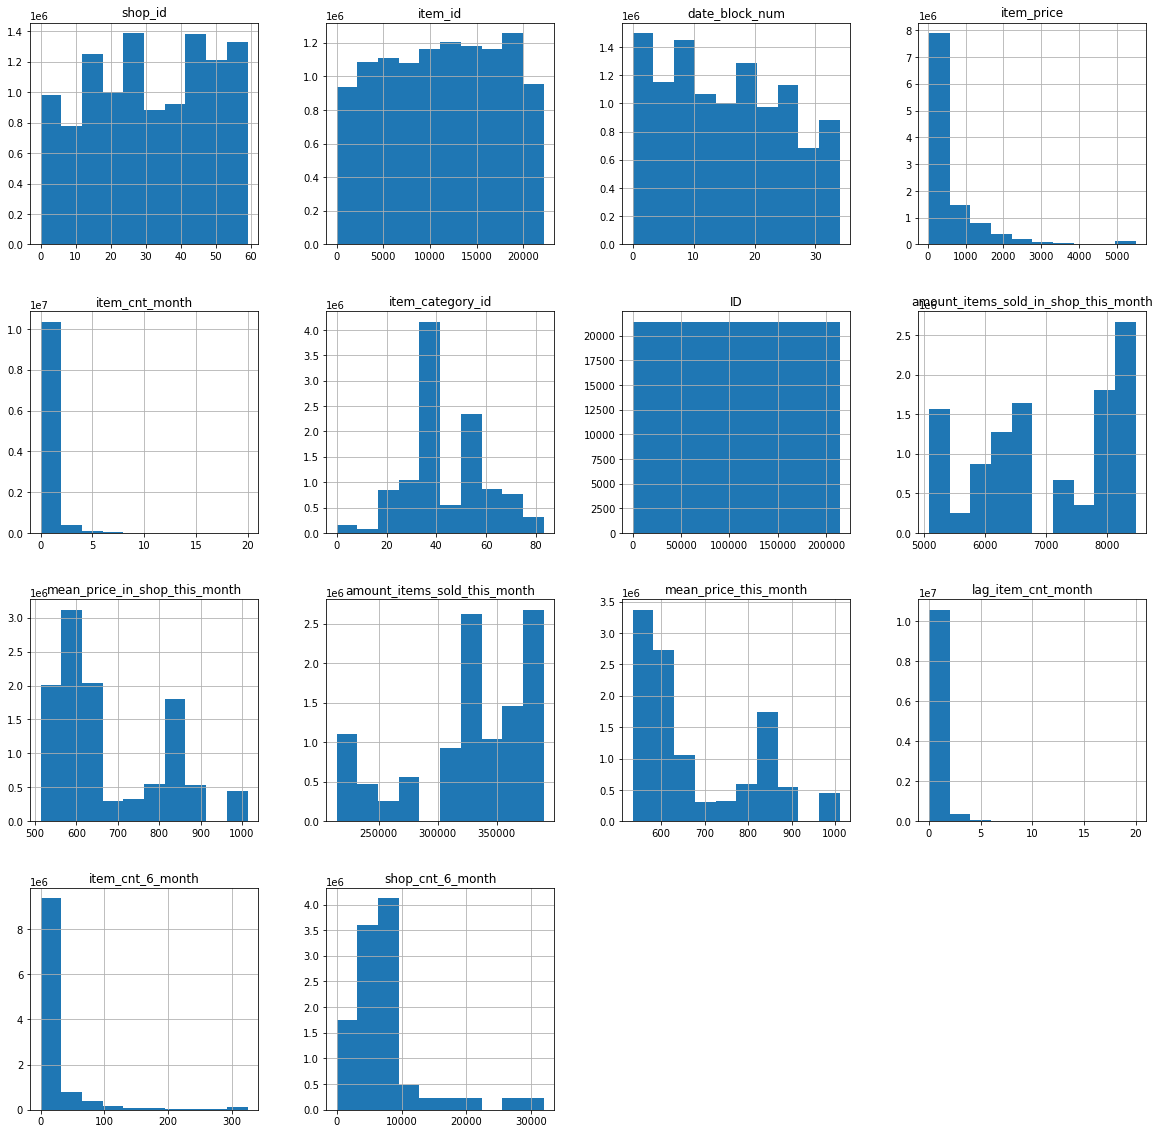

In [22]:
df.hist(figsize=(20,20))
plt.show()

In [24]:
y = df.dropna(subset=['item_cnt_month']).item_cnt_month
test_ID = df.ID.dropna()
df.drop(['ID', 'item_cnt_month'], axis = 1, inplace=True)

In [25]:
df.to_pickle("/home/maksim/ml/Predict future sales/Pickle_files/how_to_win_2.pkl")
y.to_pickle("/home/maksim/ml/Predict future sales/Pickle_files/target.pkl")
test_ID.to_pickle("/home/maksim/ml/Predict future sales/Pickle_files/test_ID.pkl")

### Test / Train split

In [2]:
import pandas as pd
import numpy as np

df = pd.read_pickle("/home/maksim/ml/Predict future sales/Pickle_files/how_to_win_2.pkl")
y = pd.read_pickle("/home/maksim/ml/Predict future sales/Pickle_files/target.pkl")

In [3]:
X_train = df[df['date_block_num'] < 33]
X_valid = df[df['date_block_num'] == 33]
X_test = df[df['date_block_num'] == 34]

y_train = y[df['date_block_num'] < 33]
y_valid = y[df['date_block_num'] == 33]

In [4]:
X_train.head()

,shop_id,item_id,date_block_num,item_price,item_category_id,amount_items_sold_in_shop_this_month,mean_price_in_shop_this_month,amount_items_sold_this_month,mean_price_this_month,lag_item_cnt_month,item_cnt_6_month,shop_cnt_6_month
0,59,22154,0,999.0,37,8115,569.368091,365175,567.550533,1.0,23.0,5555.0
1,25,22154,0,999.0,37,8115,573.188695,365175,567.550533,5.0,23.0,27450.0
2,24,22154,0,999.0,37,8115,569.282982,365175,567.550533,1.0,23.0,6709.0
3,23,22154,0,999.0,37,8115,569.595698,365175,567.550533,0.0,23.0,0.0
4,19,22154,0,999.0,37,8115,571.047572,365175,567.550533,0.0,23.0,8095.0


In [5]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(10675678, 12) (10675678,)
(238172, 12) (238172,)


# Modelling

In [50]:
def rmse(X, y):
    return np.sqrt(np.mean((X - y) ** 2))


print("baseline rmse is", np.round(rmse(X_valid.lag_item_cnt_month, y_valid), 4))

baseline rmse is 1.6034


### Random Forest

In [55]:
%%time
from sklearn.ensemble import RandomForestRegressor
reg_rf = RandomForestRegressor(n_estimators = 300, n_jobs = -1, max_depth=10, 
                               max_features=0.8, min_samples_leaf=10, bootstrap=True)
reg_rf.fit(X_train, y_train)
print('rmse train is {}'.format(np.round(rmse(reg_rf.predict(X_train), y_train),4)))
print('rmse valid is {}'.format(np.round(rmse(reg_rf.predict(X_valid), y_valid),4)))
f_importances = np.array([[X_train.columns[i],reg_rf.feature_importances_[i]] for i in range(len(X_train.columns))])
pd.DataFrame(f_importances[(f_importances[:, 1]).argsort()])

rmse train is 1.0098
rmse valid is 0.9772
CPU times: user 6h 11min 3s, sys: 1min 28s, total: 6h 12min 31s
Wall time: 48min 47s


,0,1
0,lag_item_cnt_month,0.00027593890084772664
1,mean_price_this_month,0.0066859400015017775
2,mean_price_in_shop_this_month,0.010362434896384732
3,amount_items_sold_this_month,0.02634301109975673
4,amount_items_sold_in_shop_this_month,0.026487220063808572
5,shop_id,0.03236269935463093
6,date_block_num,0.05159013185406536
7,item_id,0.06604932064688324
8,item_category_id,0.12726387920817184
9,shop_cnt_6_month,0.13154677340022866


In [6]:
import xgboost as xgb

model =  xgb.XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='approx', validate_parameters=1, verbosity=None)

In [14]:
save_for_submission(pred, "XGB_pred.csv")

### Gradient Boosting

In [ ]:
# from sklearn.ensemble import GradientBoostingRegressor

# reg = GradientBoostingRegressor(max_depth = 10)
# reg.fit(X_train, y_train)
# rmse(reg.predict(X_train), y_train)

In [182]:
save_for_submission(X_test.item_mean_cnt.values, 'all_month_subm.csv')